In [19]:
import json

LOG_DIR = "benchmark_logs"

LOG_PATH = f"{LOG_DIR}/phi4-before-system-prompt.jsonl"
LOG_PATH = f"{LOG_DIR}/deepseek-r1-14b_20250716-154120.jsonl"
LOG_PATH = f"{LOG_DIR}/sqlcoder-latest_20250716-160249.jsonl"
LOG_PATH = f"{LOG_DIR}/qwen2.5-coder-14b_20250716-162700.jsonl"
LOG_PATH = f"{LOG_DIR}/gemma3-12b_20250716-165749.jsonl"
LOG_PATH = f"{LOG_DIR}/gpt-4.1_20250716-175823.jsonl"
LOG_PATH = f"{LOG_DIR}/gpt-4.1-nano_20250716-173648.jsonl"
LOG_PATH = f"{LOG_DIR}/o3-mini_20250716-174053.jsonl"
LOG_PATH = f"{LOG_DIR}/o3_20250716-180115.jsonl"
LOG_PATH = f"{LOG_DIR}/qwen3-14b_20250716-171949.jsonl"

def find_llm_true_others_false(log_path):
    with open(log_path, "r") as f:
        lines = f.readlines()

    filtered = []
    for line in lines:
        entry = json.loads(line)
        if (
            entry.get("llm_equivalent") is False
            # entry.get("match_exact") is False and
            # entry.get("match_ast") is False
        ):
            filtered.append(entry)

    print(f"Found {len(filtered)} cases where LLM judged True but exact and AST are False.\n")

    for i, entry in enumerate(filtered, 1):
        print(f"--- Case #{i} ---")
        print(f"Example ID: {entry['example_id']}")
        print(f"Prompt:\n{entry['prompt']}\n")
        print(f"Context:\n{entry['context']}\n")
        print(f"Reference SQL:\n{entry['reference_sql']}\n")
        print(f"Generated SQL:\n{entry['generated_sql']}\n")
        print(f"LLM Explanation:\n{entry['llm_explanation']}\n")
        print("="*60)

if __name__ == "__main__":
    find_llm_true_others_false(LOG_PATH)


Found 125 cases where LLM judged True but exact and AST are False.

--- Case #1 ---
Example ID: 2656
Prompt:
Find the drugs and their respective total sales for rare diseases indication with sales greater than the average sales for infectious diseases.

Context:
CREATE TABLE sales (id INT, drug_id INT, quarter INT, year INT, revenue FLOAT); INSERT INTO sales (id, drug_id, quarter, year, revenue) VALUES (1, 1, 1, 2022, 1500000); CREATE TABLE drugs (id INT, name VARCHAR(50), company VARCHAR(50), indication VARCHAR(50)); INSERT INTO drugs (id, name, company, indication) VALUES (1, 'DrugA', 'ABC Corp', 'Rare_Diseases');

Reference SQL:
SELECT s.drug_id, d.name, SUM(s.revenue) as total_sales FROM sales s JOIN drugs d ON s.drug_id = d.id WHERE d.indication = 'Rare_Diseases' GROUP BY s.drug_id HAVING total_sales > (SELECT AVG(s2.revenue) FROM sales s2 JOIN drugs d2 ON s2.drug_id = d2.id WHERE d2.indication = 'Infectious_Diseases')

Generated SQL:
SELECT d.name, SUM(s.revenue) AS total_sales
F

In [18]:
from __future__ import annotations
import argparse, json, pathlib, sys
import pandas as pd


def load_jsonl(path: pathlib.Path) -> pd.DataFrame:
    """Read a JSONL benchmark log into a DataFrame."""
    with path.open() as fp:
        rows = [json.loads(ln) for ln in fp if ln.strip()]
    df = pd.DataFrame(rows)
    df["source_log"] = path.name          # keep origin for later
    return df


def summarise(df: pd.DataFrame) -> None:
    """Print an aggregated overview."""
    n = len(df)
    if n == 0:
        print("No rows ⇒ nothing to summarise.\n")
        return

    tot_lat   = df["latency_sec"].sum()
    tot_tok   = df["tokens_total"].fillna(0).sum()
    tot_prm   = df["tokens_prompt"].fillna(0).sum()
    tot_cmp   = df["tokens_completion"].fillna(0).sum()
    avg_lat   = tot_lat / n
    avg_tok   = tot_tok / n
    tps       = tot_tok / tot_lat if tot_lat else None

    exact_ok  = df["match_exact"].mean() * 100
    ast_ok    = df["match_ast"].mean()   * 100
    llm_ok    = df["llm_equivalent"].mean() * 100 if "llm_equivalent" in df else None

    print(f"Rows analysed          : {n:,}")
    print(f"Σ latency              : {(tot_lat/60):,.2f} min")
    print(f"Σ tokens (prompt+comp) : {tot_tok:,.0f}")
    print(f"  – prompt             : {tot_prm:,.0f}")
    print(f"  – completion         : {tot_cmp:,.0f}")
    print(f"Avg latency / query    : {avg_lat:,.2f}  s")
    print(f"Avg tokens / query     : {avg_tok:,.1f}")
    if tps:
        print(f"Overall throughput     : {tps:,.1f} tokens/sec")
    print()
    print(f"Exact-match accuracy   : {exact_ok:5.1f} %")
    print(f"AST-match accuracy     : {ast_ok:5.1f} %")
    if llm_ok is not None:
        print(f"LLM-judge equivalence  : {llm_ok:5.1f} %")
    print("-" * 40, "\n")




df = load_jsonl(pathlib.Path(LOG_PATH))
summarise(df)

Rows analysed          : 196
Σ latency              : 110.24 min
Σ tokens (prompt+comp) : 328,801
  – prompt             : 39,542
  – completion         : 289,259
Avg latency / query    : 33.75  s
Avg tokens / query     : 1,677.6
Overall throughput     : 49.7 tokens/sec

Exact-match accuracy   :   8.2 %
AST-match accuracy     :  13.3 %
LLM-judge equivalence  :  36.2 %
---------------------------------------- 



In [15]:
from text2sql_lib.visualize import visualize_benchmark_results, visualize_benchmark_results2

# visualize_benchmark_results("benchmark_results.jsonl")

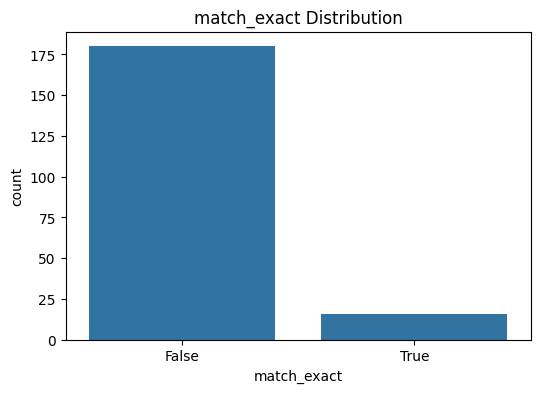

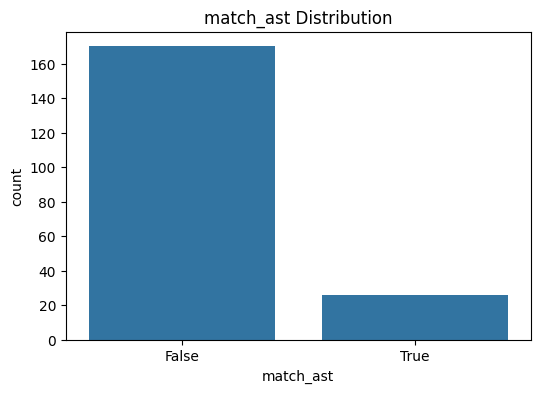

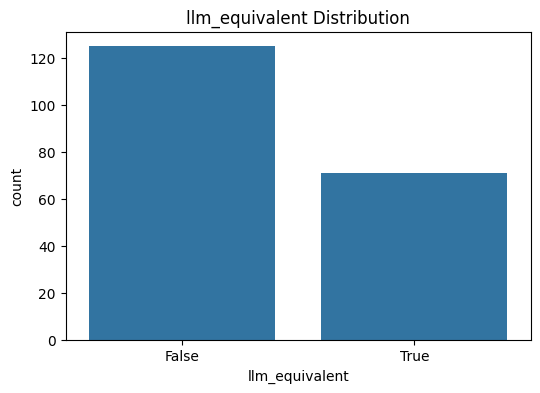

match_exact       0.081633
match_ast         0.132653
llm_equivalent    0.362245
dtype: float64


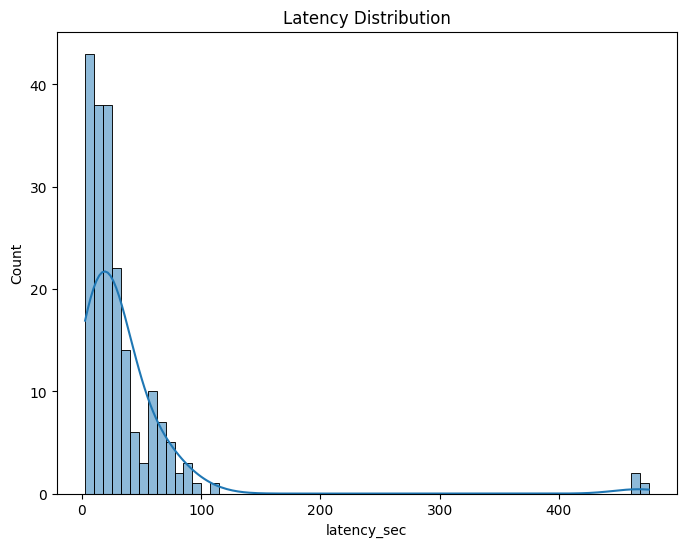

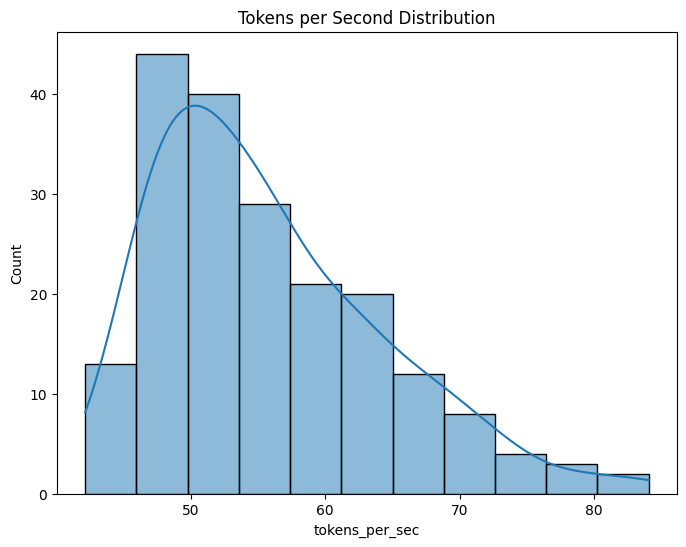

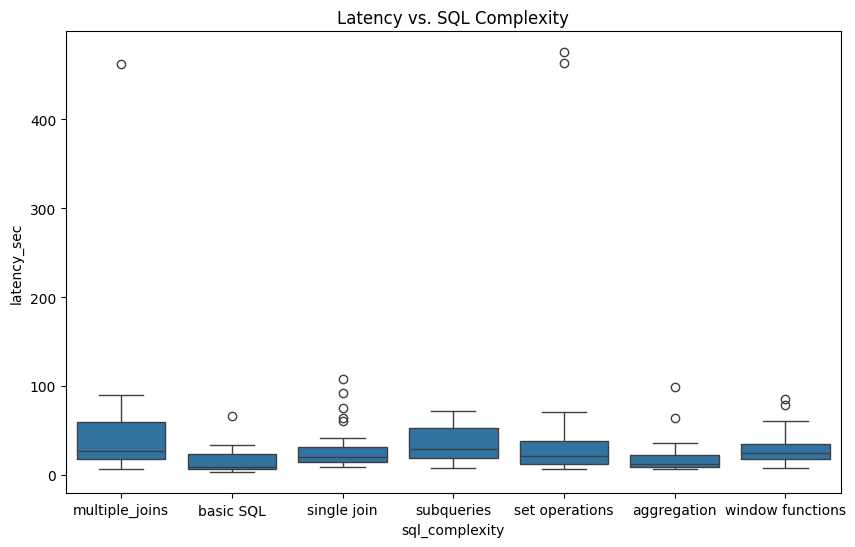

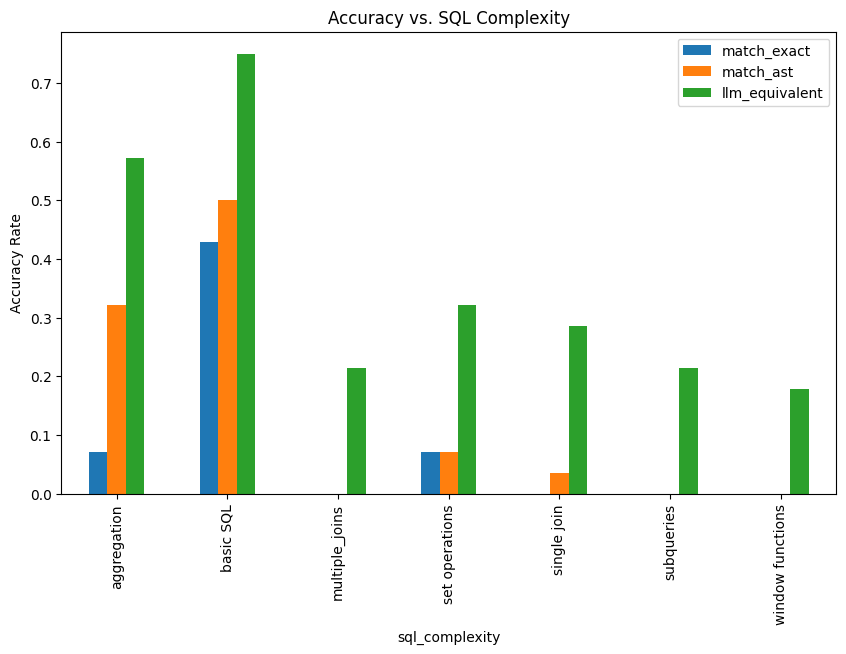

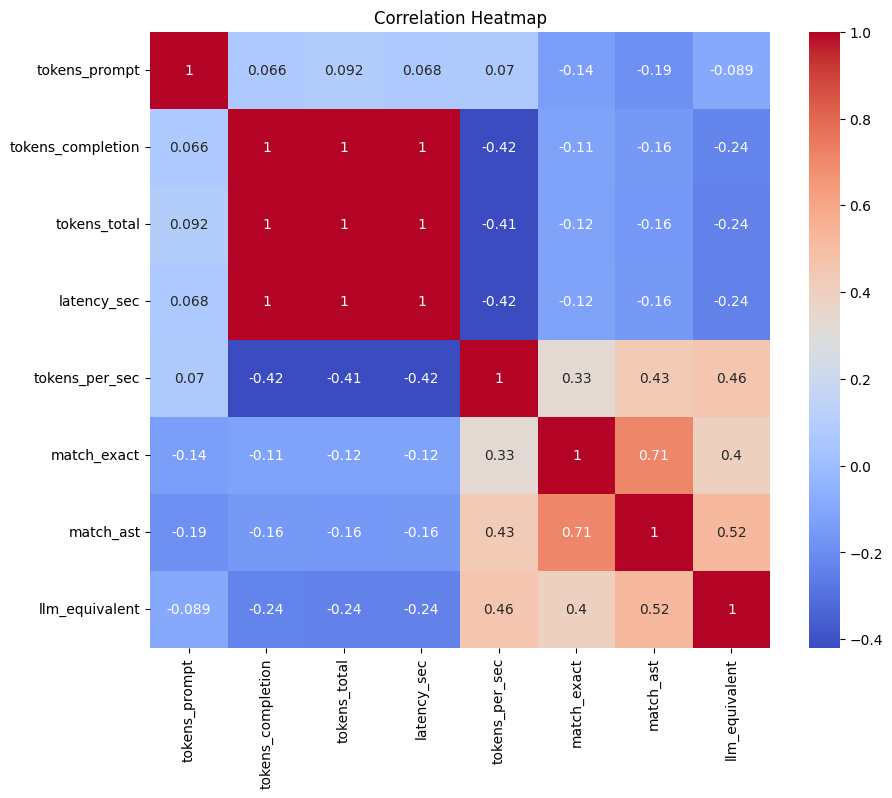

In [16]:
visualize_benchmark_results2(LOG_PATH)